# Setup

## Import Relevant Libraries

In [1]:

import pandas as pd
import numpy as np

import os

import pathlib

import requests

from scipy import stats

import matplotlib.pyplot as plt

%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 12, 10
rcParams['pdf.fonttype'] = 42
inline_rc = dict(plt.rcParams)

import platform
import sys

import geopandas as gpd

pd.options.mode.copy_on_write = True

## Version

In [2]:
print("Operating System " + platform.system() + " " + platform.release())
print("Python Version " + str(sys.version))
print("Numpy Version " + str(np.__version__))
print("Pandas Version " + str(pd.__version__))
print (os.environ['CONDA_DEFAULT_ENV'])

Operating System Windows 10
Python Version 3.11.8 | packaged by conda-forge | (main, Feb 16 2024, 20:40:50) [MSC v.1937 64 bit (AMD64)]
Numpy Version 1.26.4
Pandas Version 2.2.2
pygis311v4


## Set Main Paths

In [3]:
main_path = pathlib.Path("G:/Shared drives/UGS_Groundwater/Projects/Pahvant_Valley")
gis_path = main_path / "GIS_Pahvant"
pumpingwells = pathlib.Path("C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/pumping_wells.gpkg")
spr_data = main_path / "Python" / "DailyValues2022163816.csv"
climate_dir = main_path / "Climate_Station_Data"
pumpdata = main_path / "Groundwater_Pumping" / "Groundwater_Conditions_In_Utah.xlsx"
open_et_data = main_path / "Flow Monitoring" / "OpenET_Clear_Lake_Pool_and_Veg_ET.xlsx"
figure_dir = main_path / "Writing" / "Figures" 

## Define Some Functions

These functions pull in water use data from the water rights website and organize it into dataframes. You can select by county, WR area, or a custom polygon.  I set the functions up to use kwargs to do this.  

Based on: [https://www.waterrights.utah.gov/asp_apps/waterUseData/setFilters.asp](https://www.waterrights.utah.gov/asp_apps/waterUseData/setFilters.asp) 

In [4]:
def get_use_data(**kwargs):
    # https://waterrights.utah.gov/asp_apps/waterUseData/setFilters.asp 
    # source_type = loc_type
    url = 'https://waterrights.utah.gov/asp_apps/waterUseData/postFilters.asp?'

    kwargs['format'] = 'xml'
    #kwargs['dataDisplay'] = 'allDataSelected'
    kwargs['units'] = 'gallons'
    # kwargs['sourceTypeF'] = self.source_type
    kwargs['location'] = 'CNT'
    #kwargs['custom-area'] = "POLYGON (( -114.19261627197015 42.407614032251104, -114.11571197509531 39.56798390179124,-112.84129791259572 39.88062920761839, -112.1162002563459 40.08266760534742, -112.01732330322093 40.36786520953616, -111.66576080322102 40.484950337599685, -111.54491119384602 40.739322538829576, -111.74266510009608 41.55008465917799, -111.97887115478356 41.558306042945794, -111.97337799072086 42.2736244443845,-111.98436431884588 42.265494687355336, -114.19261627197015 42.407614032251104))"
    kwargs['county'] = 'Millard'#location
    kwargs['output'] = 'all'
    #kwargs['pwsUseOut'] = 'pwsUseOutSelected'
    #kwargs['indOutputSelect'] = 'indOutputSelected'
    #kwargs['mgtOutputSelect'] = 'mgtOutputSelected'
    utwr_dict = requests.get(url, params=kwargs)
    print(utwr_dict.url)
    return utwr_dict


def pull_records_xml(**kwargs):
    import xml.etree.ElementTree as ET
    outdata = get_use_data(**kwargs)
    root = ET.fromstring(outdata.text)
    
    sysdfs, srcdfs, rcddfs, usedfs= {},{},{},{}
     
    for system in root.findall('SYSTEM'):
        cols = [child.tag for child in system]
        sysdat, sourcedat, recorddat, usedat = {}, {}, {}, {}

        for child in system:
            if child.tag =='SOURCES':
                sysdat['NUM_SOURCES'] = len([src.tag for src in child.findall('SOURCE')])
                for src in child.findall('SOURCE'):
                    sourcedat['SYSTEM_ID'] = system.find('SYSTEM_ID').text
                    for srcchild in src:
                        if srcchild.tag == 'RECORDS':
                            for rec in srcchild.findall('RECORD'):
                                recorddat['SOURCE_ID'] = sourcedat['SOURCE_ID']
                                for recchild in rec:
                                    recorddat[recchild.tag] = recchild.text
                                rcddfs[f"{recorddat['SOURCE_ID']}_{recorddat['RECORD_YEAR']}"] =  pd.DataFrame.from_dict(recorddat, orient='index').T
                        sourcedat[srcchild.tag] = srcchild.text
                    srcdfs[sourcedat['SOURCE_ID']] = pd.DataFrame.from_dict(sourcedat, orient='index').T
            elif child.tag == 'USES':
                for use in child.findall('USE'):
                    usedat['SYSTEM_ID'] = system.find('SYSTEM_ID').text
                    for usechild in use:
                        usedat[usechild.tag] = usechild.text
                    usedfs[f"{usedat['SYSTEM_ID']}_{usedat['HISTORY_YEAR']}"] = pd.DataFrame.from_dict(usedat, orient='index').T

            else:
                sysdat[child.tag] = system.find(child.tag).text
        sysdfs[sysdat['SYSTEM_NAME']] = pd.DataFrame.from_dict(sysdat, orient='index').T

    df_systems = pd.concat(sysdfs).reset_index().set_index('SYSTEM_ID').drop(['level_1','level_0'],axis=1)
    df_sources = pd.concat(srcdfs).reset_index().set_index('SOURCE_ID').drop(['level_1','level_0'],axis=1)
    df_records = pd.concat(rcddfs).reset_index().rename(columns={'level_0':'RECORD_ID'}).set_index('RECORD_ID').drop(['level_1'],axis=1)
    df_uses = pd.concat(usedfs).reset_index().set_index('SYSTEM_ID').drop(['level_1','level_0'],axis=1)

    datasets = [df_systems,df_sources,df_records,df_uses]

    for dset in datasets:
        dset = lowercols(dset)

    df_records = recordunstack(df_records)
    df_systems.index = pd.to_numeric(df_systems.index)
    df_uses.index = pd.to_numeric(df_uses.index)
    df_sources['system_id'] = pd.to_numeric(df_sources['system_id'])
    
    return df_systems, df_uses, df_sources, df_records
    
    

def pull_records(**kwargs):
    
    outdata = get_use_data(**kwargs)
    sys_types = ['MGT_SYSTEMS','PWS_SYSTEMS','IND_SYSTEMS']
    systms, srces, rcrds, us = {},{},{},{}

    for sys_type in sys_types:
        systems = pd.DataFrame.from_dict(outdata.json()[sys_type])
        systems.columns = [str(i).lower() for i in systems.columns]
        systems['system_id'] = systems['system_id'].apply(lambda x: int(x),1)
        systems = systems.set_index('system_id')
        if 'deq_id' in systems.columns:
            systems['deq_id'] = systems['deq_id'].apply(lambda x: None if x.strip() == '' else pd.to_numeric(x,errors='coerce',downcast='integer'), 1)


        source = {}
        for sysid in systems.index:
            df = pd.DataFrame.from_dict(systems.loc[sysid,'sources'])
            df.columns = [str(i).lower() for i in df.columns]
            df['system_id'] = int(sysid)
            source[sysid] = df
        sources = pd.concat(source,ignore_index=True)
        sources['lat'] = sources['lat'].apply(lambda x: pd.to_numeric(x, errors='coerce'),1)
        sources['lon'] = sources['lon'].apply(lambda x: pd.to_numeric(x, errors='coerce'),1)

        sources = sources.set_index('source_id')

        record = {}
        for srcid in sources.index:
            df = pd.DataFrame.from_dict(sources.loc[srcid,'records'])
            if len(df)>0:
                df['source_id'] = srcid
                df.columns = [str(i).lower() for i in df.columns]
                df['record_id'] = df[['source_id','record_year']].apply(lambda x: f"{x[0]}-{x[1]}",1)
                record[srcid] = df
        records = pd.concat(record,ignore_index=True) 
        records = records.set_index('record_id')
        records_unstack = recordunstack(records)

        use = {}
        for sysid in systems.index:
            df = pd.DataFrame.from_dict(systems.loc[sysid,'water_uses'])
            df.columns = [str(i).lower() for i in df.columns]
            df['system_id'] = int(sysid)
            df['wateruse_id'] = df[['system_id','history_year']].apply(lambda x: f"{x[0]}-{x[1]}",1)
            use[sysid] = df
        uses = pd.concat(use,ignore_index=True)
        uses = uses.set_index('wateruse_id')
        for col in uses.columns:
            if "use" in col:
                uses[col] = pd.to_numeric(uses[col], errors='coerce')
            elif "connections" in col:
                uses[col] =  uses[col].apply(lambda x: None if pd.isnull(x) or x.strip() == '' else int(x), 1)

        for col in ['sources', 'water_uses','peak_demands']:
            if col in systems.columns:
                systems = systems.drop(col,axis=1)

        if 'records' in sources.columns:
            sources = sources.drop('records', axis=1)


        systms[sys_type] = systems
        srces[sys_type] = sources
        rcrds[sys_type] = records_unstack
        us[sys_type] = uses

    allsystems = pd.concat(systms)#, ignore_index=True)
    allsources = pd.concat(srces)#, ignore_index=True)
    allrecords = pd.concat(rcrds)#, ignore_index=True)
    alluses = pd.concat(us)#, ignore_index=True)
    return allsystems, alluses, allsources, allrecords

def lowercols(df):
    df.columns = [str(col).lower() for col in df.columns]
    df.index.name = df.index.name.lower()
    return df

def recordunstack(recrds):
    unstack_records = recrds.drop(['total'],axis=1).reset_index().set_index(['record_id','source_id','record_year']).stack().reset_index().rename(columns={'level_3':'month',0:'wuse'})
    unstack_records['date'] = pd.to_datetime(unstack_records['month'].str.title() + " " + unstack_records['record_year'].astype(str), format="%b %Y", errors='coerce')
    unstack_records = unstack_records.drop(['record_id','month','record_year'],axis=1)
    unstack_records = unstack_records.dropna(subset=['date'])
    unstack_records['sourcedate_id'] = unstack_records['source_id'].astype(str) + "-" +unstack_records['date'].dt.strftime('%Y%m')
    unstack_records.index.name = 'oldindex'
    unstack_records = unstack_records.reset_index().set_index('sourcedate_id').drop(['oldindex'],axis=1)
    unstack_records['wuse'] = pd.to_numeric(unstack_records['wuse'])
    return unstack_records

# Well Flow Readings

## Bring in Water Rights Data

This pulls all of the Water Rights Water Use data for the region using the above functions.  It creates 4 dataframes: Systems, Water Uses, Sources, and Records

In [5]:
systems, wtr_uses, sources, recrds = pull_records_xml()
tables = ['wtrsystem','wtruse','wtrsource','userecords']
dfs = [systems, wtr_uses, sources,recrds]

https://waterrights.utah.gov/asp_apps/waterUseData/postFilters.asp?format=xml&units=gallons&location=CNT&county=Millard&output=all


Match WINs to Sources.  I cheated and did this in ArcGIS Pro then copied and pasted into an Excel Spreadsheet.

In [6]:
win_match = pd.read_excel(gis_path / "WR_WU_Pumping_Match.xlsx",na_values="<Null>",index_col='source_id')
win_match.index = win_match.index.astype(str)
win_match_dict = win_match['WIN'].astype(int).to_dict()


Sources encompass all of Millard county.  Limit them to Pahvant and save as a GIS file.

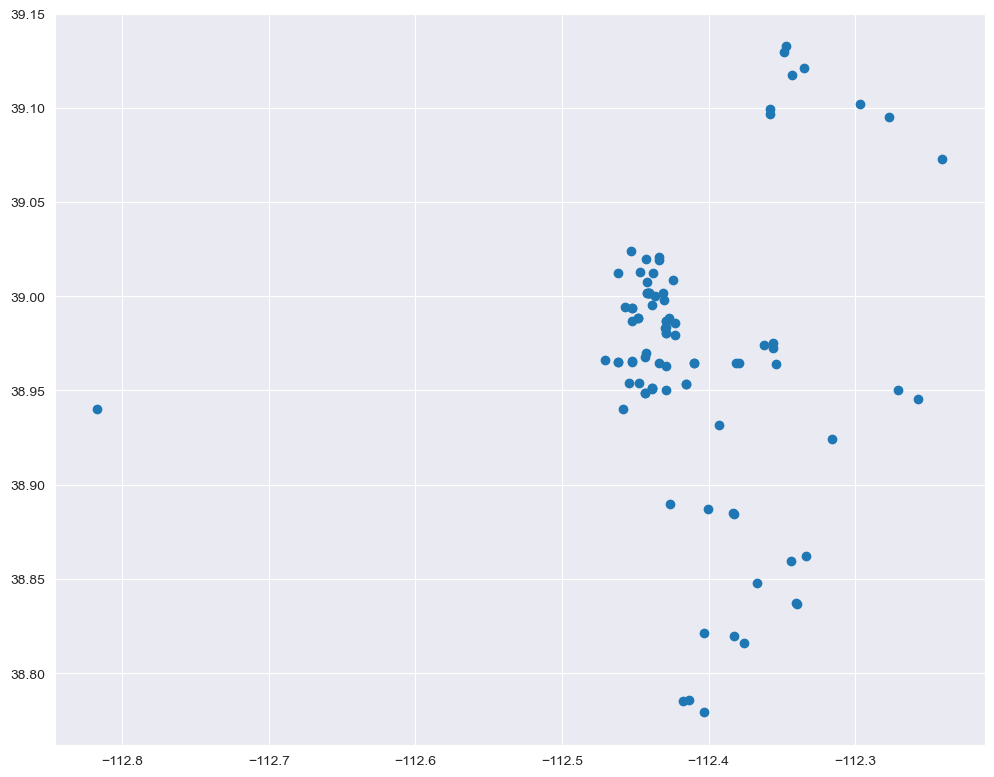

In [7]:
sources = sources[(pd.to_numeric(sources['lon']) > -112.9)&(pd.to_numeric(sources['lat']) < 39.23)&(pd.to_numeric(sources['lon']) < -112.12)&(pd.to_numeric(sources['lat']) > 38.64)]
sources_geo = gpd.GeoDataFrame(sources, geometry=gpd.points_from_xy(sources.lon, sources.lat), crs="EPSG:4326")
sources_geo.plot()
sources_geo.to_file(gis_path / "WaterRights_sources.gpkg", layer="sources")
sourcetype = sources_geo['use_type'].to_dict()

In [8]:
sources['use_type'].unique()

array(['Water Supplier', 'Agricultural', 'Irrigation', 'Mining',
       'Industrial', 'Domestic'], dtype=object)

## Pull reported pumping records

In [141]:
localrecrds = recrds[recrds['source_id'].isin(sources_geo.index)]
localrecrds['WIN'] =localrecrds['source_id'].map(win_match_dict)
localrecrds['daysinmonth'] = localrecrds['date'].dt.daysinmonth
localrecrds['Source Type'] = localrecrds['source_id'].map(sourcetype)
gpmest = localrecrds[(localrecrds['wuse']>1000)&(localrecrds['Source Type'].isin(['Irrigation','Agricultural']))&(localrecrds['date'].dt.month.isin([4,5,6,7,8,9,10]))]
gpmest['gal per day'] = gpmest['wuse']/gpmest['daysinmonth']
gpmest['gpm'] = gpmest['gal per day']* 0.000694444
gpmdata = gpmest.groupby('source_id').max()
#gpmdata['WIN'] = gpmdata.index.map(win_match_dict)
gpmdata = gpmdata[gpmdata['gpm'] > 10]

In [12]:
source_id =108545927

yearlyuse = recrds[recrds['source_id'].isin(sources_geo.index)].groupby(['source_id',pd.Grouper(key='date',freq='YE')]).sum().loc[str(source_id)]*0.00000306889
print(yearlyuse)
print(yearlyuse.median())
print(yearlyuse.iloc[-2,0])

                  wuse
date                  
2020-12-31  506.864010
2021-12-31  212.413221
2022-12-31  218.262526
2023-12-31  189.442580
wuse    215.337874
dtype: float64
218.26252569000002


### Municipal Well Pumping Data

In [143]:
munic_wells = sources[(sources['use_type'].isin(['Domestic','Water Supplier'])) & (sources['source_status'].isin(['Active'])) & (sources['source_type'].isin(['Well']))]

print(munic_wells)

yearly_municipal_use = localrecrds[localrecrds['source_id'].isin(munic_wells.index)].groupby([localrecrds['source_id'],localrecrds['date'].dt.year]).sum(numeric_only=True)

uses_2022 = yearly_municipal_use[yearly_municipal_use.index.get_level_values(1)==2022]
Total_Use_2022 = uses_2022.sum()['wuse']*0.00000306889
print(f"Municipal Pumping in 2022 was {Total_Use_2022:0.0f} ac-ft/yr")

1270.192960159393


### Industrial Well Pumping Data

In [147]:
indust_wells = sources[(sources['use_type'].isin(['Mining','Industrial'])) & (sources['source_status'].isin(['Active'])) & (sources['source_type'].isin(['Well']))]


yearly_industrial_use = localrecrds[localrecrds['source_id'].isin(indust_wells.index)].groupby([localrecrds['source_id'],localrecrds['date'].dt.year]).sum(numeric_only=True)

indust_uses_2022 = yearly_industrial_use[yearly_industrial_use.index.get_level_values(1)==2022]
Total_Industrial_Use_2022 = indust_uses_2022.sum()['wuse']*0.00000306889
print(f"Industrial Pumping in 2022 was {Total_Industrial_Use_2022} ac-ft")

137.867121249


## Bring in UGS Data

In [16]:
welldf = pd.read_csv(gis_path / "Meter_Readings_XYTableToPoint.csv",na_values=['<Null>'],parse_dates=True)
welldf = welldf.drop(['OBJECTID *','Inspector','GUID','GlobalID *'],axis=1)
# Only keep values that have a WIN
welldf = welldf[pd.notna(welldf['WIN'])]
# Convert WIN to integer
welldf['WIN'] = welldf['WIN'].astype(int) 
welldf['InspectionDate'] = pd.to_datetime(welldf['InspectionDate'],errors='coerce')
welldf['InspectMonth'] = welldf['InspectionDate'].dt.month_name()


## Check Initial Distribution of Irrigation Flows

Total number of flow measurments: 30


<Axes: >

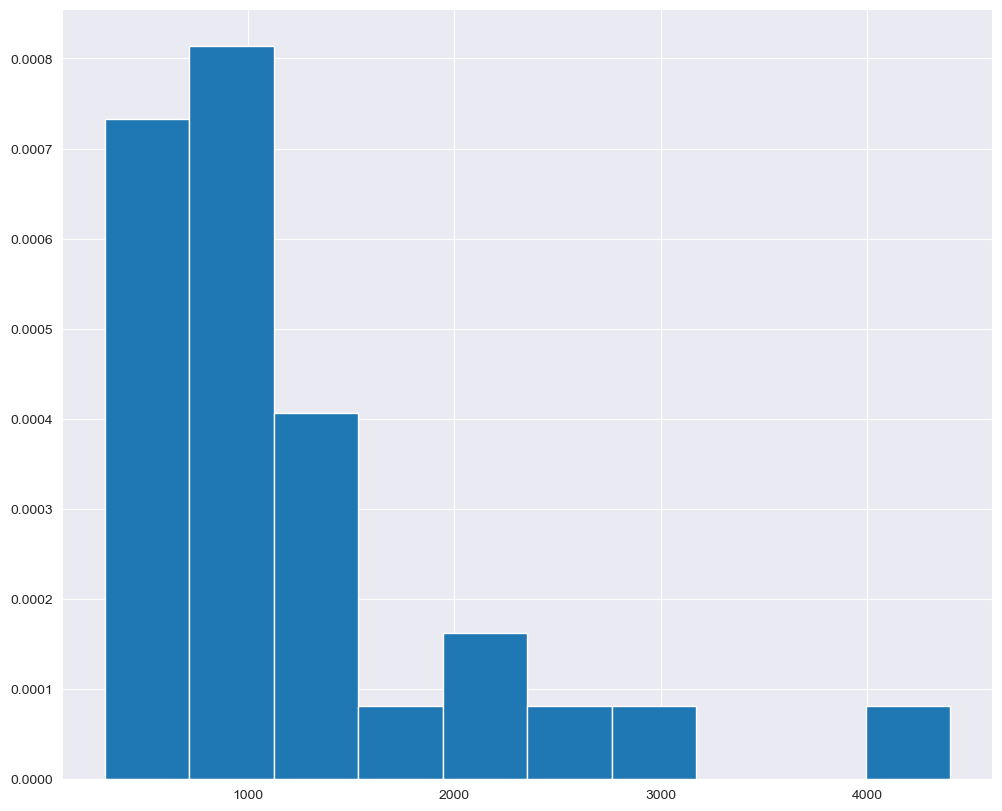

In [17]:
flows = welldf.dropna(subset=['WellFlowReading']).groupby('WIN').max(numeric_only=True)
flows = flows[flows['WellFlowReading']>0]
gpm_dict = flows['WellFlowReading'].to_dict()
print(f"Total number of flow measurments: {len(flows)}")
flows['WellFlowReading'].hist(density=True)


plt.xlabel("Flow")

From the limited sample set, the distribution of pump rates for the valley irrigation wells looks lognormal.  That makes sense, as there should be many wells with smaller rates and some wells with higher rates. Model the distribution of irrigation pumping rates based on the measured sample.

In [18]:
flows['WellFlowReading'].describe()

count      30.000000
mean     1198.614000
std       899.046931
min       306.890000
25%       596.837500
50%       976.750000
75%      1398.375000
max      4402.500000
Name: WellFlowReading, dtype: float64

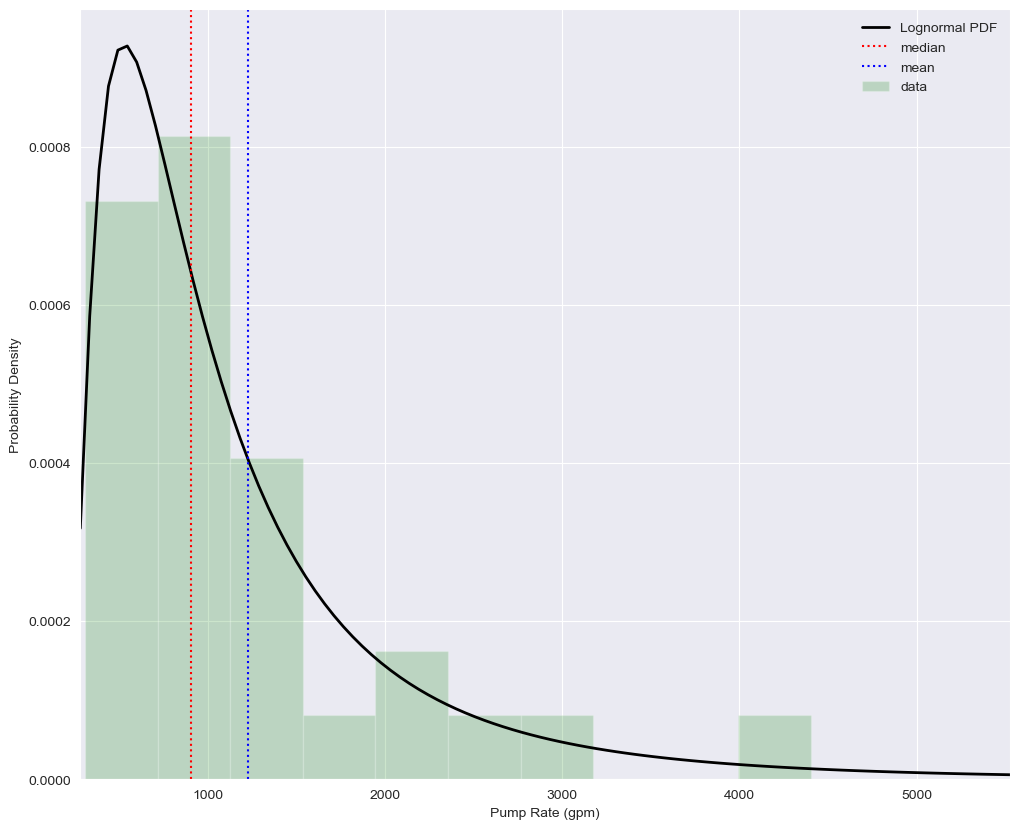

probability of being close to 800: 14.74 %
95% confidence interval between 315 and 4082 gpm
Median: 903.1760484393992


<Figure size 1200x1000 with 0 Axes>

In [19]:
lognm = stats.lognorm.fit(flows['WellFlowReading'])
testdist = stats.lognorm(*lognm)

fig, ax = plt.subplots(1, 1)
r = testdist.rvs(size=1000)
x = np.linspace(testdist.ppf(0.01), testdist.ppf(0.99), 100)
ax.plot(x, testdist.pdf(x), 'k-', lw=2, label='Lognormal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(testdist.median(),label='median',color='red',linestyle=":")
ax.axvline(testdist.mean(),label='mean',color='blue',linestyle=":")
flows['WellFlowReading'].hist(density=True,ax=ax, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')

#ax.plot(x,stats.lognorm.pdf(x,s=0.86071,loc=181.25,scale=721.9262),linestyle=":",color='pink')

ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Pump Rate (gpm)")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

val = 800
eps = 100
prob_close_to_val = testdist.cdf(val + eps) - testdist.cdf(val - eps)
print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {testdist.interval(confidence)[0]:0.0f} and {testdist.interval(confidence)[-1]:0.0f} gpm")
print(f"Median: {testdist.median()}")
plt.savefig(figure_dir / "pumping_rate_dist.png")
plt.savefig(figure_dir / "pumping_rate_dist.pdf")

In [20]:
mean, var, skew, kurt = testdist.stats(moments='mvsk')
print(mean, var, skew, kurt)

1226.9094215422483 1200502.3075272087 4.293957878608008 45.04422427868851


In [21]:
lognm 

(0.8607905851386943, 181.24984285621588, 721.9262055831833)

## Combine Water Rights and UGS Data and Fit Distribution

probability of being close to 800: 12.46 %
95% confidence interval between 77 and 3312 gpm
Median: 836.2953438169113


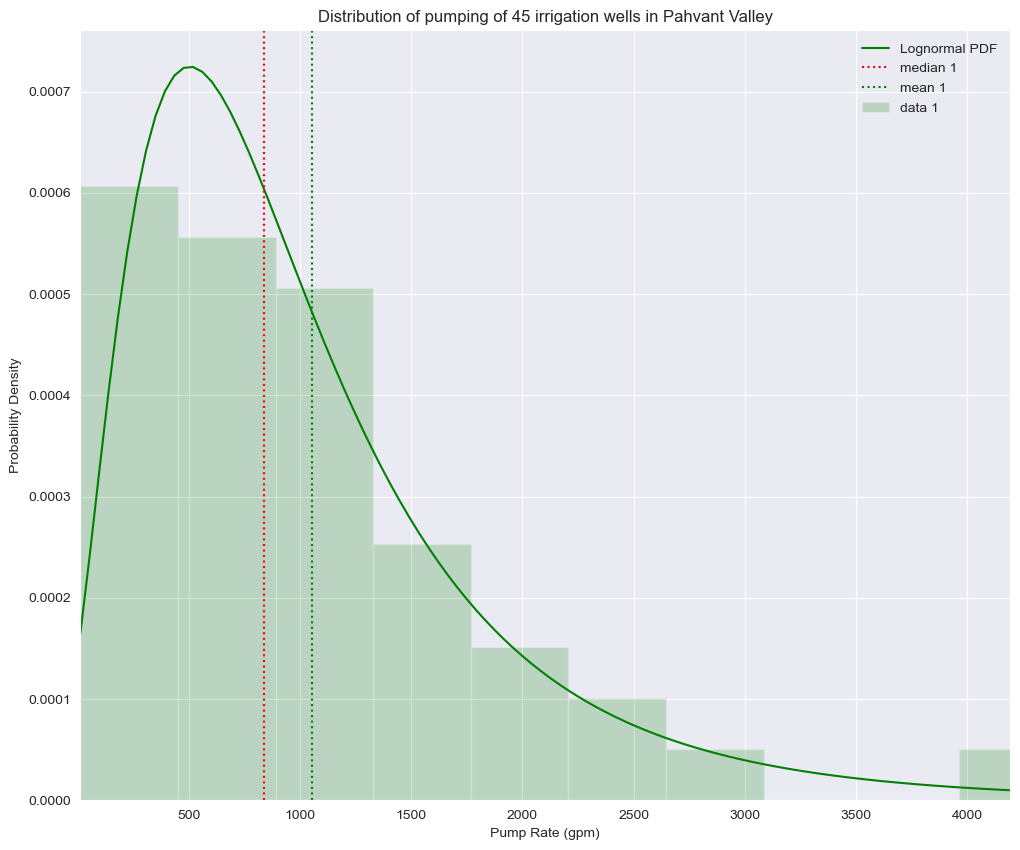

<Figure size 1200x1000 with 0 Axes>

In [22]:
#gpmdata['gpm'].hist()
gpmsubset = gpmdata.dropna(subset=['WIN']).set_index(['WIN'])['gpm']
gpmsubset.index = gpmsubset.index.astype(int)
gpmall = pd.concat([flows['WellFlowReading'],gpmsubset]).reset_index().drop_duplicates(subset=['WIN']).set_index(['WIN']).sort_index()


lognm = stats.lognorm.fit(gpmall)
testdist = stats.lognorm(*lognm)

fig, ax = plt.subplots(1, 1)

r = testdist.rvs(size=1000)
x = np.linspace(testdist.ppf(0.01), testdist.ppf(0.99), 100)
ax.plot(x, testdist.pdf(x), label='Lognormal PDF', color='green')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(testdist.median(),label='median 1',color='red',linestyle=":")
ax.axvline(testdist.mean(),label='mean 1',color='green',linestyle=":")
gpmall.hist(density=True,ax=ax, color='green',alpha=0.2,label='data 1')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Pump Rate (gpm)")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)


val = 800
eps = 100
prob_close_to_val = testdist.cdf(val + eps) - testdist.cdf(val - eps)
print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
print(f"{confidence*100:0.0f}% confidence interval between {testdist.interval(confidence)[0]:0.0f} and {testdist.interval(confidence)[-1]:0.0f} gpm")
print(f"Median: {testdist.median()}")

plt.title(f"Distribution of pumping of {len(gpmall)} irrigation wells in Pahvant Valley")


plt.show()

plt.savefig(figure_dir / "pumping_rate_dist_all_irr_wells.png")
plt.savefig(figure_dir / "pumping_rate_dist_all_irr_wells.pdf")

In [178]:
stats.gmean(gpmall)

array([722.1343828])

# Totalizer Readings

We recorded totalizer measurements where possible.  If pump rate is known, we can back-calculate the total amount of time each well is pumped.

In [23]:
volume_readings = welldf[['WIN','InspectMonth','WellTotalReading']].dropna().groupby(['WIN','InspectMonth']).mean().unstack(level=1).droplevel(0, axis=1)
volume_readings = volume_readings.reindex(['March','August','September','November'], axis=1)
total_volumes = volume_readings.dropna(subset=['March','November'])
total_volumes['total (gallons)'] = (total_volumes['November'] - total_volumes['March'])*1000
total_volumes ['total (ac-ft)'] = total_volumes['total (gallons)']*3.06889e-6
total_volumes['pump rate (gpm)'] = total_volumes.index.map(gpm_dict)
total_volumes['hours pumped (hr)'] = total_volumes['total (gallons)'] / total_volumes['pump rate (gpm)'] /60
total_volumes

InspectMonth,March,August,September,November,total (gallons),total (ac-ft),pump rate (gpm),hours pumped (hr)
WIN,,,,,,,,
919,69218.90,129804.0,NaN,139397.40,70178500.0,215.370097,498.76,2345.099179
1077,14.20,454489.5,NaN,573346.20,573332000.0,1759.492841,3071.79,3110.737822
1124,56067.20,94802.9,NaN,103364.50,47297300.0,145.150211,395.51,1993.093306
2309,113601.60,199180.6,NaN,199180.60,85579000.0,262.632537,NaN,NaN
3524,0.00,42183.1,NaN,42183.80,42183800.0,129.457442,NaN,NaN
3525,201412.70,357734.4,NaN,398910.40,197497700.0,606.098717,967.70,3401.496676
3528,162733.50,298689.2,NaN,338610.20,175876700.0,539.746246,957.57,3061.163501
3802,222145.00,395598.2,NaN,457235.60,235090600.0,721.467191,NaN,NaN
3828,136503.30,262329.8,NaN,290520.30,154017000.0,472.661231,NaN,NaN


In [24]:
total_volumes.to_clipboard()

In [25]:
len(volume_readings.dropna(subset=['August','November'])[['August','November']])

32

# Pumping Duration

If you know the pump rate and the total gallons pumped, then you can get the pumping duration from that information.  This is less accurate because the pump rate can be variable in many cases.

In [26]:
total_volumes['hours pumped (hr)'].dropna()

WIN
919       2345.099179
1077      3110.737822
1124      1993.093306
3525      3401.496676
3528      3061.163501
13666     7216.300530
439393    2465.383410
444873    8190.136903
Name: hours pumped (hr), dtype: float64

Vibration meters can record the amount of time a motor is running based on the vibrations that it senses.

In [27]:
vibe_readings = welldf[['WIN','InspectMonth','VibeSensorReading']].dropna().groupby(['WIN','InspectMonth']).max().unstack(level=1).droplevel(0, axis=1)
vibe_readings = vibe_readings.reindex(['March','August','November'], axis=1)
vibe_readings['pump rate (gpm)'] = vibe_readings.index.map(gpm_dict)
vibe_readings['Total Pumped (gallons)'] = vibe_readings['pump rate (gpm)'] * 60 * vibe_readings['November']
vibe_readings['Total Pumped (ac-ft)'] = vibe_readings['Total Pumped (gallons)'] * 3.06889e-6
vibe_readings.to_clipboard()
vibe_readings
#vibe_readings['Aug-Nov Vibe'] = (total_volumes['November'] - total_volumes['March'])*3.06889e-6*1000

InspectMonth,March,August,November,pump rate (gpm),Total Pumped (gallons),Total Pumped (ac-ft)
WIN,,,,,,
922,0.0,3003.2,3408.9,4402.50,9.004609e+08,2763.415559
924,0.0,2228.4,2755.1,2461.52,4.069040e+08,1248.743694
1013,0.0,NaN,2702.5,1109.00,1.798244e+08,551.861149
1077,0.0,NaN,3251.4,3071.79,5.992571e+08,1839.054061
3407,0.0,2625.0,3759.3,NaN,NaN,NaN
3497,0.0,NaN,2756.3,NaN,NaN,NaN
3802,0.0,1771.0,932.3,NaN,NaN,NaN
23719,0.0,2651.8,4110.5,NaN,NaN,NaN
25266,0.0,NaN,NaN,NaN,NaN,NaN


Combine datasets from vibration sensors with duration estimates from complete pumping records.

In [28]:
pump_dur= pd.concat([total_volumes['hours pumped (hr)'].dropna(),
                     vibe_readings.rename(columns={'November':'hours pumped (hr)'})['hours pumped (hr)']]).drop([35696,31756,444873,3802,13666],axis=0)/24
len(pump_dur)

19

In [29]:
pump_dur

WIN
919        97.712466
1077      129.614076
1124       83.045554
3525      141.729028
3528      127.548479
439393    102.724309
922       142.037500
924       114.795833
1013      112.604167
1077      135.475000
3407      156.637500
3497      114.845833
23719     171.270833
25266            NaN
26844      96.454167
35697      46.316667
99990     112.679167
429388    147.341667
433640    102.166667
Name: hours pumped (hr), dtype: float64

In [30]:
print(f"Apr 1 to Nov 1 = {(pd.to_datetime('2022-11-01') - pd.to_datetime('2022-04-01')).days} days")
print(f"May 1 to Oct 1 = {(pd.to_datetime('2022-10-01') - pd.to_datetime('2022-05-01')).days} days")
print(f"Jun 1 to Oct 1 = {(pd.to_datetime('2022-10-01') - pd.to_datetime('2022-06-01')).days} days")

print(f"Max pump duration: {pump_dur.max():0.0f} days ({pump_dur.max()*24:0.0f} hr)")
print(f"Median pump duration: {pump_dur.median():0.0f} days ({pump_dur.median()*24:0.0f} hr)")
print(f"Min pump duration: {pump_dur.min():0.0f} days ({pump_dur.min()*24:0.0f} hr)")

Apr 1 to Nov 1 = 214 days
May 1 to Oct 1 = 153 days
Jun 1 to Oct 1 = 122 days
Max pump duration: 171 days (4110 hr)
Median pump duration: 115 days (2756 hr)
Min pump duration: 46 days (1112 hr)


In [31]:
norm_pump_dur = stats.norm.fit(pump_dur.dropna())
pump_dur_dist = stats.norm(*norm_pump_dur)
pump_dur_dist.mean()

118.61105067864615

## Plot Distribution of Pumping Duration Data

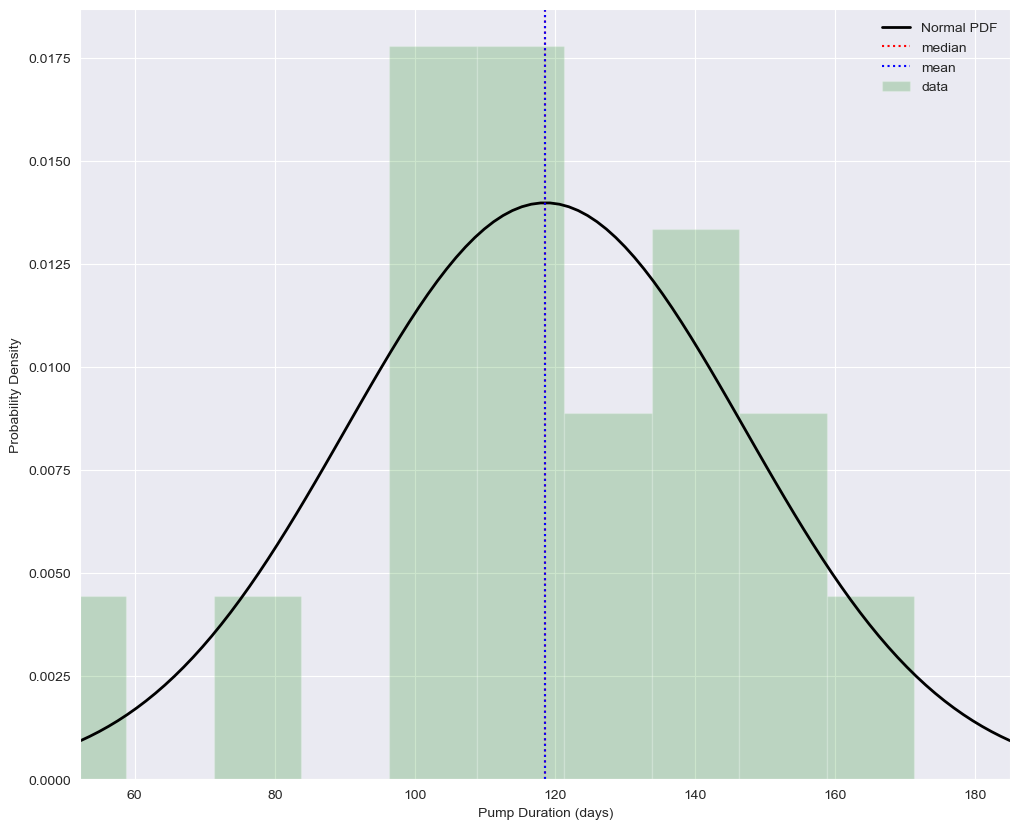

<Figure size 1200x1000 with 0 Axes>

In [32]:
fig, ax = plt.subplots(1, 1)
r = pump_dur_dist.rvs(size=1000)
x = np.linspace(pump_dur_dist.ppf(0.01), pump_dur_dist.ppf(0.99), 100)
ax.plot(x, pump_dur_dist.pdf(x), 'k-', lw=2, label='Normal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(pump_dur_dist.median(),label='median',color='red',linestyle=":")
ax.axvline(pump_dur_dist.mean(),label='mean',color='blue',linestyle=":")
pump_dur.hist(density=True,ax=ax, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel("Pump Duration (days)")
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

val = 100
eps = 5
prob_close_to_val = pump_dur_dist.cdf(val + eps) -pump_dur_dist.cdf(val - eps)
#print(f"probability of being close to {val}: {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %
confidence = 0.95
plt.savefig(figure_dir / "pumping_rate_duration.png")
plt.savefig(figure_dir / "pumping_rate_duration.pdf")
#print(f"{confidence*100:0.0f}% confidence interval between {pump_dur_dist.interval(confidence)[0]:0.0f} and {pump_dur_dist.interval(confidence)[-1]:0.0f} days")

In [175]:
print(np.quantile(pump_dur_dist.rvs(size=1000),0.025))
print(np.quantile(pump_dur_dist.rvs(size=1000),0.975))
print(np.quantile(pump_dur_dist.rvs(size=1000),0.5))
print(np.std(pump_dur_dist.rvs(size=1000)))

65.67854565204539
175.36289110604125
119.70912608468834
27.67518336940508


# Model Total Well Pumping

In [34]:
pumping_wells = gpd.read_file(pumpingwells)#.groupby('MainUse')
pumpers = pumping_wells[pumping_wells['inuse'] == "T"][['geometry','MainUse']]

well_count= pumpers.groupby('MainUse').count()
well_count

<Axes: >

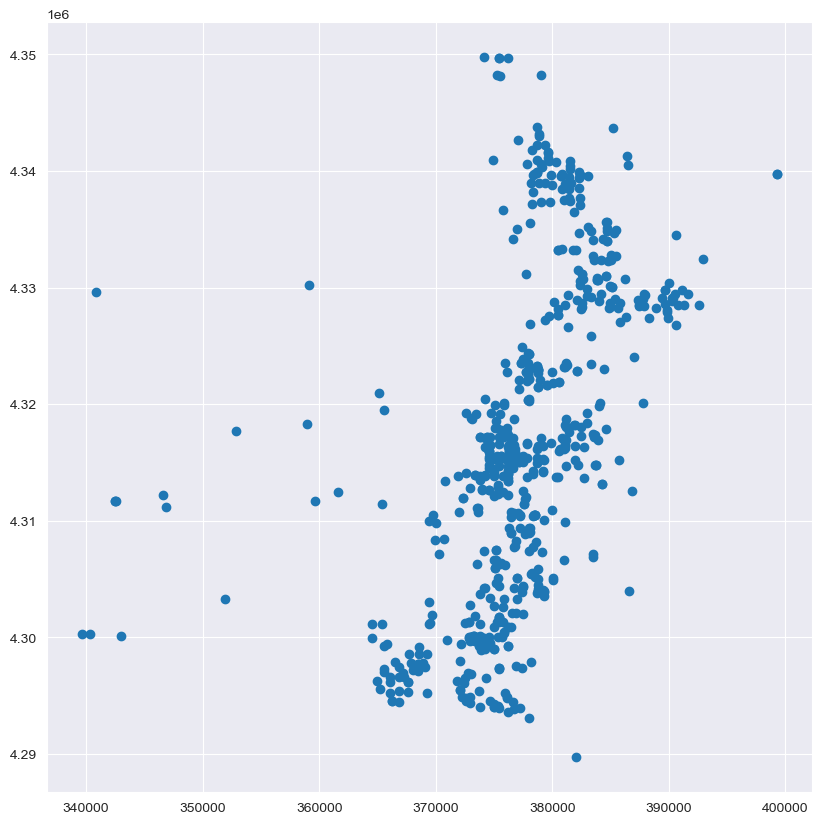

In [36]:
pumping_wells.plot()

You can run a simulation by randomly selecting from the 2 distributions you created 5000 times and multiplying the selections: Duration x Pump Rate = Total Pumping

It is good to know the total number of wells that are pumping, as the calculation is sensitive to this.

### Municipal & Industrial Pumping

Municipal and industrial pumping is relatively well constrained, with some error related to unreported pumping and errors in reported pumping.

In [1]:
fig, ax = plt.subplots(1,2)

# Create a normal distribution with the specified mean and standard deviation
municipal_pumping = stats.norm(loc=1270, scale=30) # Mean (μ), Standard deviation (σ)
industrial_pumping = stats.norm(loc=137, scale=15) # Mean (μ), Standard deviation (σ)

# Generate values from this distribution
munic_values = municipal_pumping.rvs(size=1000)
indust_values = industrial_pumping.rvs(size=1000)

# Plot the histogram of the generated values
ax[0].hist(munic_values, bins=30, density=True, alpha=0.6, color='b')
ax[1].hist(indust_values, bins=30, density=True, alpha=0.6, color='b')

# Plot the probability density function (PDF) of the normal distribution
xm = np.linspace(min(munic_values), max(munic_values), 100)
xi = np.linspace(min(indust_values), max(indust_values), 100)

ax[0].plot(x, municipal_pumping.pdf(x), 'k-', linewidth=2)
ax[1].plot(x, industrial_pumping.pdf(x), 'k-', linewidth=2)

ax[0].xlabel("Municipal Pumping (acft/yr)")
ax[1].xlabel("Industrial Pumping Duration (acft/yr)")

plt.show()

NameError: name 'plt' is not defined

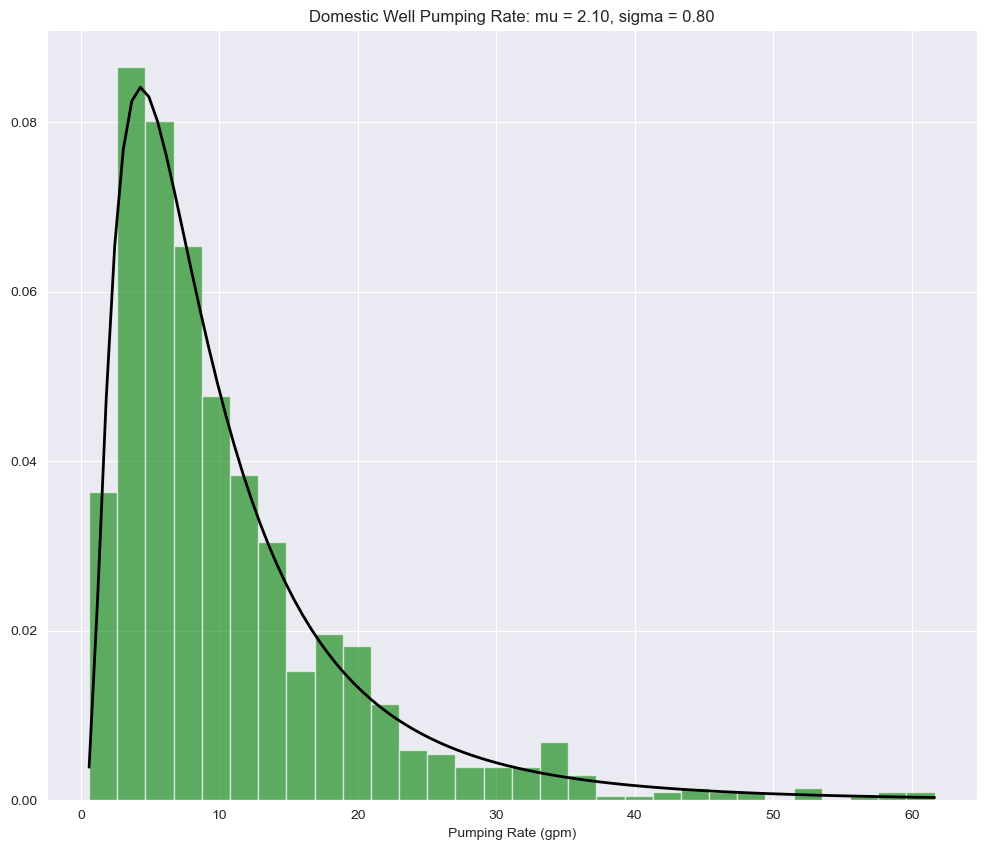

In [126]:
# Parameters for the underlying normal distribution
mu = 2.1  # Mean of the underlying normal distribution
sigma = 0.8  # Standard deviation of the underlying normal distribution

# Create a lognormal distribution
# scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
s = sigma
scale = np.exp(mu)
distribution = stats.lognorm(s=s, scale=scale)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='g')

# Plot the probability density function (PDF) of the lognormal distribution
x = np.linspace(min(values), max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
title = f"Domestic Well Pumping Rate: mu = {mu:.2f}, sigma = {sigma:.2f}"
plt.xlabel("Pumping Rate (gpm)")
plt.title(title)
plt.show()

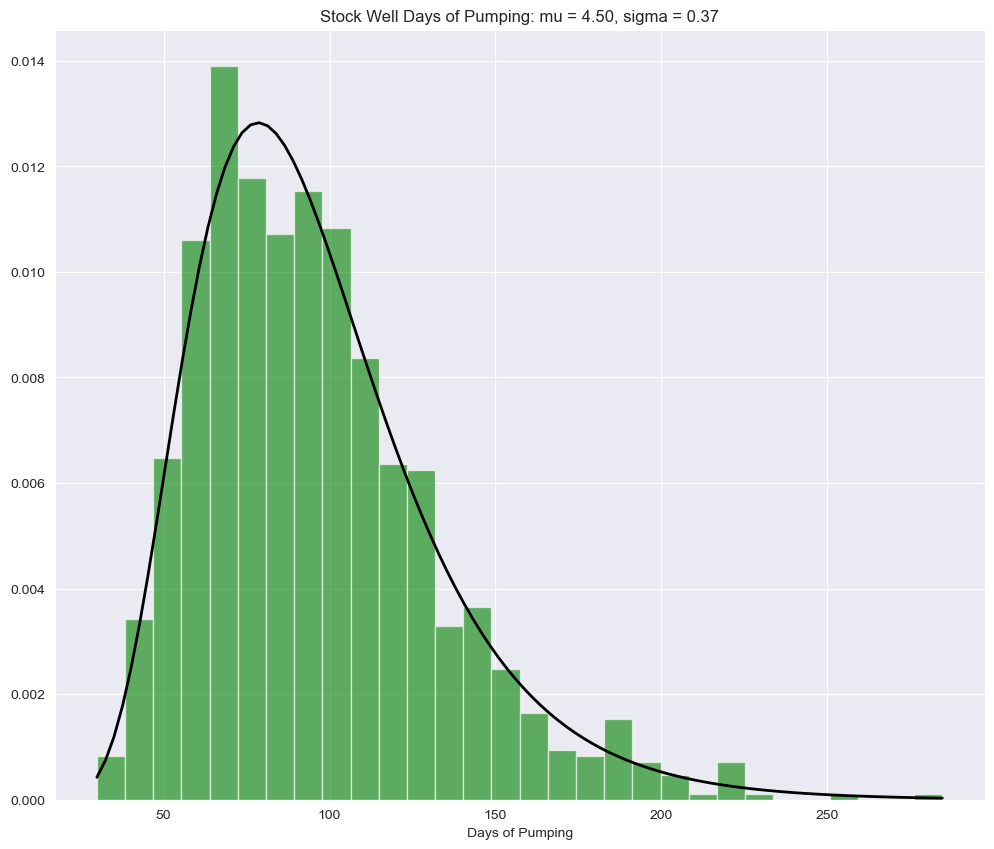

In [154]:
mu = 4.5  # Mean of the underlying normal distribution
sigma = 0.37  # Standard deviation of the underlying normal distribution

# Create a lognormal distribution
# scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
s = sigma
scale = np.exp(mu)
distribution = stats.lognorm(s=s, scale=scale)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='g')

# Plot the probability density function (PDF) of the lognormal distribution
x = np.linspace(min(values), max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
plt.xlabel("Days of Pumping")
title = f"Stock Well Days of Pumping: mu = {mu:.2f}, sigma = {sigma:.2f}"
plt.title(title)
plt.show()

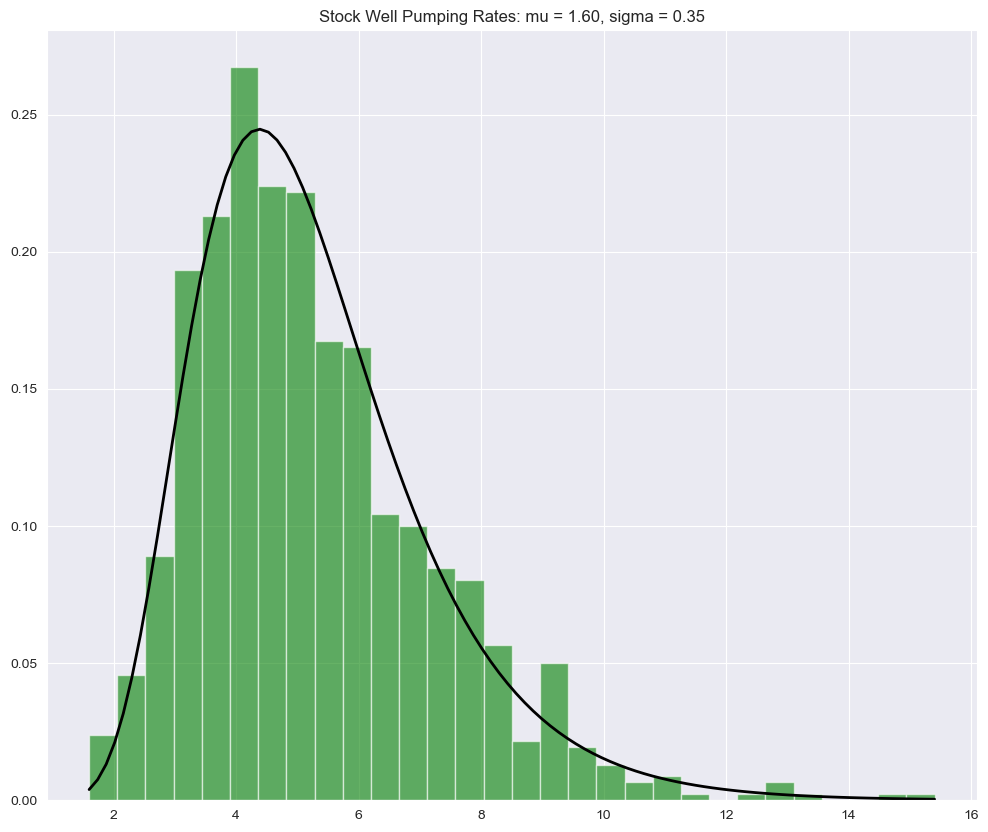

In [111]:
# Parameters for the underlying normal distribution
mu = 1.6  # Mean of the underlying normal distribution
sigma = 0.35  # Standard deviation of the underlying normal distribution

# Create a lognormal distribution
# scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
s = sigma
scale = np.exp(mu)
distribution = stats.lognorm(s=s, scale=scale)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='g')

# Plot the probability density function (PDF) of the lognormal distribution
x = np.linspace(min(values), max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
title = f"Stock Well Pumping Rates: mu = {mu:.2f}, sigma = {sigma:.2f}"
plt.title(title)
plt.show()

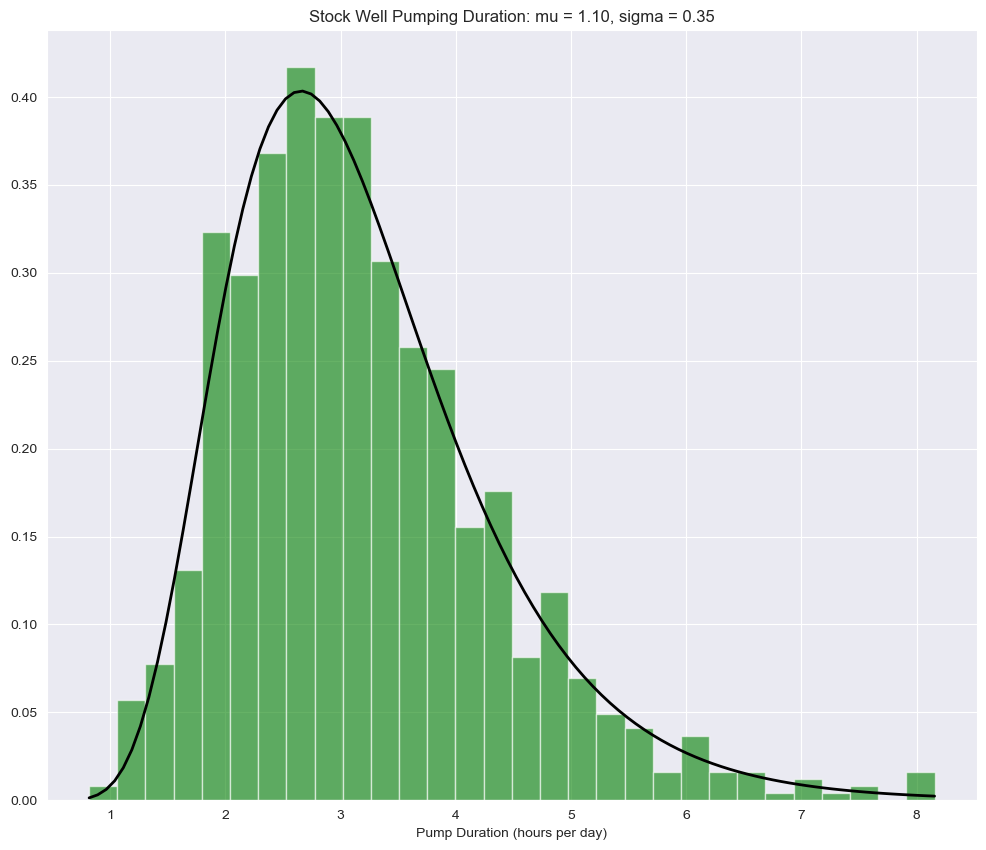

In [124]:
# Parameters for the underlying normal distribution
mu = 1.1  # Mean of the underlying normal distribution
sigma = 0.35  # Standard deviation of the underlying normal distribution

# Create a lognormal distribution
# scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
s = sigma
scale = np.exp(mu)
distribution = stats.lognorm(s=s, scale=scale)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='g')

# Plot the probability density function (PDF) of the lognormal distribution
x = np.linspace(min(values), max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
title = f"Stock Well Pumping Duration: mu = {mu:.2f}, sigma = {sigma:.2f}"
plt.xlabel("Pump Duration (hours per day)")
plt.title(title)
plt.show()

(143361.5241531788, 7880.904213210181)
(25.989105870414416, 1.8986686700505404)
(807.5901392836198, 63.20656362071417)
(145602.60735506887, 7880.482535850397)


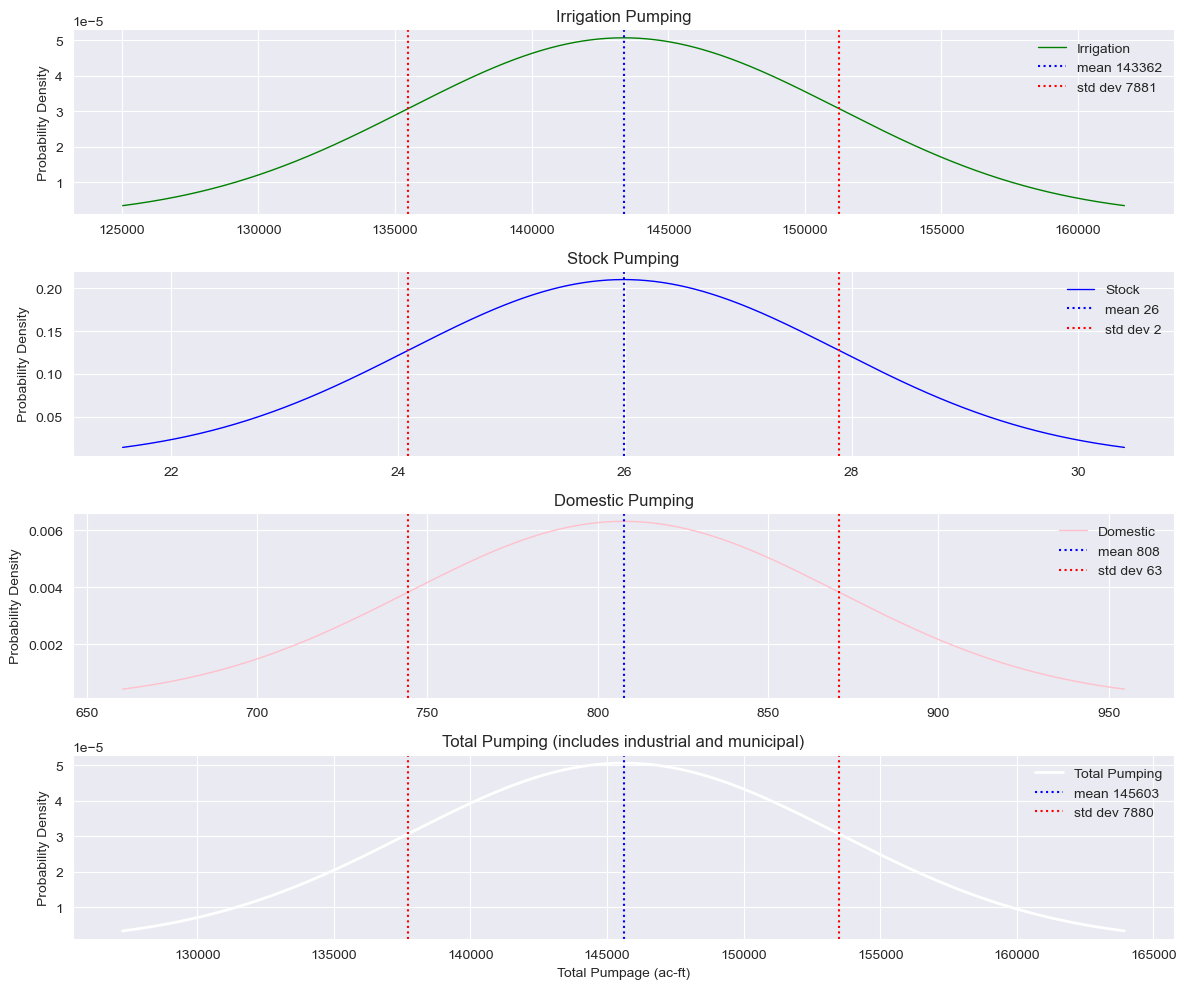

In [167]:
n_irr_wells = 259
n_dom_wells = 178
n_stk_wells = 87

dom_gpm_dist = stats.lognorm(s=0.8,scale=np.exp(2.1))
dom_hr_dist = stats.norm(6,1.7)

stk_gpm_dist = stats.lognorm(s=0.35,scale=np.exp(1.6))
stk_day_dist = stats.lognorm(s=0.37,scale=np.exp(4.5))
stk_hr_dist = stats.lognorm(s=0.35,scale=np.exp(1.1))

mun_pumping_dist = stats.norm(loc=1270, scale=30)
ind_pumping_dist = stats.norm(loc=137, scale=15)

total_irr_pumped_model = []
total_dom_pumped_model = []
total_stk_pumped_model = []
total_pumping_model = []

for i in range(5000):
    irr_pumping = np.sum(pump_dur_dist.rvs(size=n_irr_wells) * 24 * 60 * testdist.rvs(size=n_irr_wells) * 3.06889e-6)
    dom_pumping = np.sum(dom_gpm_dist.rvs(size=n_dom_wells ) * 60 * dom_hr_dist.rvs(size=n_dom_wells) * 365.25 * 3.06889e-6)
    stk_pumping = np.sum(stk_gpm_dist.rvs(size=n_stk_wells)* 60 * stk_hr_dist.rvs(size=n_stk_wells) * stk_day_dist.rvs(size=n_stk_wells) * 3.06889e-6)
    mun_pumping = mun_pumping_dist.rvs(size=1)[0]
    ind_pumping = ind_pumping_dist.rvs(size=1)[0]
    
    total_irr_pumped_model.append(irr_pumping)
    total_dom_pumped_model.append(dom_pumping)
    total_stk_pumped_model.append(stk_pumping)
    total_pumping_model.append(np.sum([irr_pumping,dom_pumping,stk_pumping,mun_pumping,ind_pumping]))
    
totalq_irr_param = stats.norm.fit(total_irr_pumped_model)
totalq_stk_param = stats.norm.fit(total_stk_pumped_model)
totalq_dom_param = stats.norm.fit(total_dom_pumped_model)
totalq_param = stats.norm.fit(total_pumping_model)

qdist = stats.norm(*totalq_param)
irr_qdist = stats.norm(*totalq_irr_param)
stk_qdist = stats.norm(*totalq_stk_param)
dom_qdist = stats.norm(*totalq_dom_param)

print(totalq_irr_param)
print(totalq_stk_param)
print(totalq_dom_param)
print(totalq_param)

fig, ax = plt.subplots(4, 1)
rt = qdist.rvs(size=1000)
ri = irr_qdist.rvs(size=1000)
rs = stk_qdist.rvs(size=1000)
rd = dom_qdist.rvs(size=1000)

xi = np.linspace(irr_qdist.ppf(0.01), irr_qdist.ppf(0.99), 1000)
xs = np.linspace(stk_qdist.ppf(0.01), stk_qdist.ppf(0.99), 1000)
xd = np.linspace(dom_qdist.ppf(0.01), dom_qdist.ppf(0.99), 1000)
xt = np.linspace(qdist.ppf(0.01), qdist.ppf(0.99), 1000)

ax[0].plot(xi, irr_qdist.pdf(xi), color='green', lw=1, label='Irrigation')
ax[1].plot(xs, stk_qdist.pdf(xs), color='blue', lw=1, label='Stock')
ax[2].plot(xd, dom_qdist.pdf(xd), color='pink', lw=1, label='Domestic')
ax[3].plot(xt, qdist.pdf(xt), color= 'white', lw=2, label='Total Pumping')

#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
#ax[3].axvline(qdist.median(),label='median',color='red',linestyle=":")
ax[0].axvline(irr_qdist.mean(), label=f'mean {irr_qdist.mean():0.0f}', color='blue', linestyle=":")
ax[0].axvline(irr_qdist.mean()+irr_qdist.std(), color='red', linestyle=":")
ax[0].axvline(irr_qdist.mean()-irr_qdist.std(), label=f'std dev {irr_qdist.std():0.0f}', color='red', linestyle=":")

ax[1].axvline(stk_qdist.mean(), label=f'mean {stk_qdist.mean():0.0f}', color='blue', linestyle=":")
ax[1].axvline(stk_qdist.mean()+stk_qdist.std(), color='red', linestyle=":")
ax[1].axvline(stk_qdist.mean()-stk_qdist.std(), label=f'std dev {stk_qdist.std():0.0f}', color='red', linestyle=":")

ax[2].axvline(dom_qdist.mean(), label=f'mean {dom_qdist.mean():0.0f}', color='blue', linestyle=":")
ax[2].axvline(dom_qdist.mean()+dom_qdist.std(), color='red', linestyle=":")
ax[2].axvline(dom_qdist.mean()-dom_qdist.std(), label=f'std dev {dom_qdist.std():0.0f}', color='red', linestyle=":")

ax[3].axvline(qdist.mean(), label=f'mean {qdist.mean():0.0f}', color='blue', linestyle=":")
ax[3].axvline(qdist.mean()+qdist.std(), color='red', linestyle=":")
ax[3].axvline(qdist.mean()-qdist.std(), label=f'std dev {qdist.std():0.0f}', color='red', linestyle=":")

#ax.hist(total_irr_pumped_model, density=True, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
#ax[0].set_xlim(xi[0], xi[-1])
#ax[1].set_xlim(xs[0], xs[-1])
#ax[2].set_xlim(xd[0], xd[-1])
#ax[3].set_xlim(xt[0], xt[-1])
ax[0].set_title("Irrigation Pumping")
ax[1].set_title("Stock Pumping")
ax[2].set_title("Domestic Pumping")
ax[3].set_title("Total Pumping (includes industrial and municipal)")

#ax[1].legend(loc='best', frameon=False)
ax[3].set_xlabel('Total Pumpage (ac-ft)')
ax[0].set_ylabel("Probability Density")
ax[1].set_ylabel("Probability Density")
ax[2].set_ylabel("Probability Density")
ax[3].set_ylabel("Probability Density")

ax[0].legend(loc='best', frameon=False)
ax[1].legend(loc='best', frameon=False)
ax[2].legend(loc='best', frameon=False)
ax[3].legend(loc='best', frameon=False)

fig.tight_layout()
plt.savefig(figure_dir / "total_pumpage_distribution.png")
plt.savefig(figure_dir / "total_pumpage_distribution.pdf")

In [185]:
print(np.quantile(ind_pumping_dist.rvs(size=1000),0.025))
print(np.quantile(ind_pumping_dist.rvs(size=1000),0.975))
print(np.quantile(ind_pumping_dist.rvs(size=1000),0.5))
print(np.std(ind_pumping_dist.rvs(size=1000)))

105.98930609840055
166.09919925631266
137.10808415986656
15.649411133251402


In [135]:
val = 147526
eps = 10000
prob_close_to_val = qdist.cdf(val + eps) - qdist.cdf(val - eps)

print(f"Assuming {n_irr_wells} irrigation wells:")

print(f"probability of being close to {val} ac-ft (USGS 2021 est): {prob_close_to_val * 100:.2f} %")
# probability of being close to 0.5: 12.95 %

confidence = 0.95
print(f"Average Estimate: {qdist.mean():0.0f} acft/yr")
print(f"Std Dev: {qdist.std():0.0f} acft/yr")
print(f"{confidence*100:0.0f}% confidence interval between {qdist.interval(confidence)[0]:0.0f} and {qdist.interval(confidence)[-1]:0.0f} acft")

Assuming 259 irrigation wells:
probability of being close to 147526 ac-ft (USGS 2021 est): 74.26 %
Average Estimate: 143939 acft/yr
Std Dev: 8025 acft/yr
95% confidence interval between 128209 and 159668 acft


In [137]:
yr_rcds['Source Type'].unique()

array(['Water Supplier', nan, 'Agricultural', 'Industrial', 'Irrigation',
       'Domestic', 'Mining'], dtype=object)

In [140]:
recrds['year'] = recrds['date'].dt.year

yr_rcds = recrds.groupby(['source_id','year']).sum(numeric_only=True)*0.00000306889
yr_rcds['Source Type'] = yr_rcds.index.get_level_values(0).map(sourcetype)
yr_rcds[(yr_rcds['Source Type'].isin(['Water Supplier']))&(yr_rcds['wuse']>0)&(yr_rcds.index.get_level_values(1)==2022)]['wuse'].sum()#/115*226.285

2761.885957081733

<Axes: xlabel='date'>

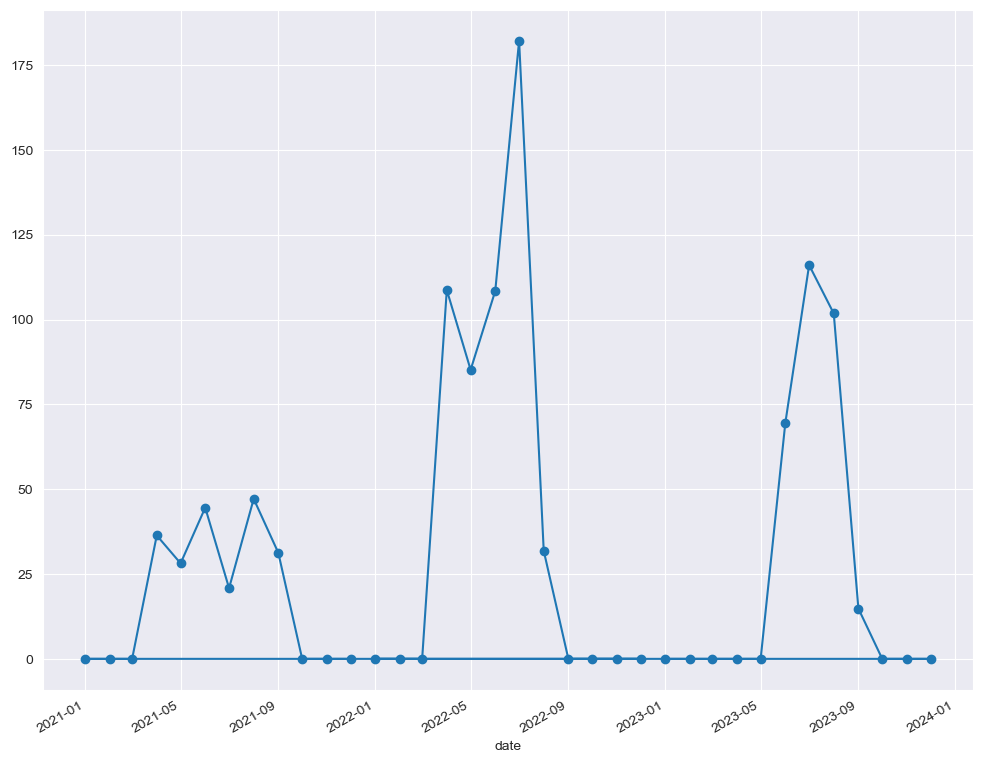

In [38]:
test_field = localrecrds.reset_index().set_index(['source_id','date']).loc['108546337']
test_field['wateruse (ac-ft)'] = test_field['wuse']*3.06889e-6
test_field['wateruse (ac-ft)'].plot(marker="o")

# Electrical Reading Comparison

Water Use Records for 2022 from Water Rights

In [39]:

q2022 = localrecrds[(localrecrds['wuse']>1000)&(localrecrds['Source Type'].isin(['Irrigation']))&(localrecrds.date.dt.year==2022)&(localrecrds['date'].dt.month.isin([4,5,6,7,8,9,10]))].groupby(['WIN']).sum(numeric_only=True)['wuse']*3.06889e-6
q2022.index = q2022.index.astype(int)

f2022= localrecrds[(localrecrds['wuse']>1000)&(localrecrds['Source Type'].isin(['Irrigation']))&(localrecrds['date'].dt.year==2022)&(localrecrds['date'].dt.month.isin([9,10,11]))].groupby(['WIN']).sum(numeric_only=True)['wuse']*3.06889e-6
f2022.index = f2022.index.astype(int)

#total_volumes['wr check'] = total_volumes.index.map(q2022.to_dict())
yr_use = pd.concat([total_volumes['total (ac-ft)'],q2022])
fall_use = pd.concat([(volume_readings['November'] - volume_readings['August']).dropna(),f2022])

Field Readings of Power Use

In [40]:
electric_readings = welldf[['WIN','InspectMonth','MeterReading']].dropna().groupby(['WIN','InspectMonth']).max().unstack(level=1).droplevel(0, axis=1)

electric_readings['total_usage'] = electric_readings['November'] - electric_readings['March']
electric_readings['fall_usage'] = electric_readings['November'] - electric_readings['August']

electric_readings['acft'] = electric_readings.index.map(yr_use.to_dict())
electric_readings['fallacft'] = electric_readings.index.map(fall_use.to_dict())


#electric_readings_fall = electric_readings.reindex(['March','August','November'], axis=1)
#electric_readings_total = electric_readings.reindex(['March','August','November'], axis=1).dropna(subset=['March','November'])

In [41]:
electric_readings[['total_usage','acft']].where(electric_readings['total_usage']>0).dropna()

InspectMonth,total_usage,acft
WIN,,
922,15153.0,2985.072476
924,3216.0,1086.337958
3525,8432.0,606.098717
3802,18808.0,721.467191
3828,15518.0,472.661231
6522,9861.0,1038.022674
13666,5527.0,668.367262
444873,26253.0,664.609866


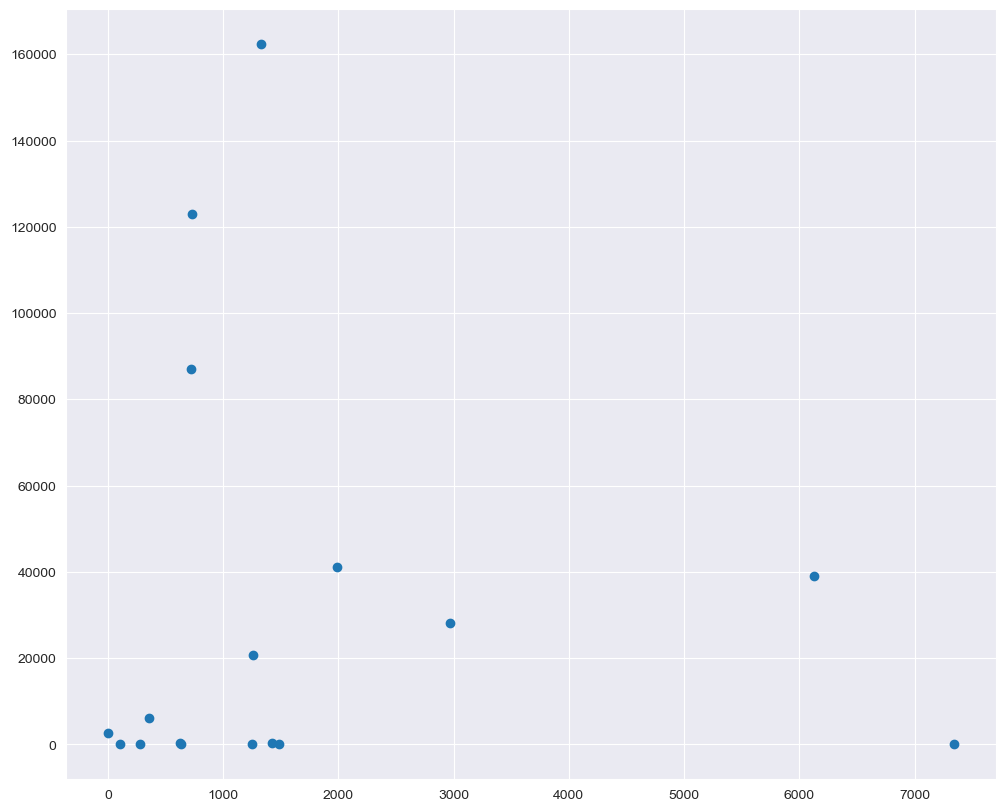

In [42]:
fallcomp = electric_readings[['fall_usage','fallacft']].where(electric_readings['fall_usage']>0).where(electric_readings['fallacft']>0).dropna()

x = fallcomp['fall_usage']
y = fallcomp['fallacft']

plt.scatter(x,y)

In [43]:

elec_comparison = electric_readings[(electric_readings['total_usage']>0)&(pd.notna(electric_readings['total_usage']))&(pd.notna(electric_readings['acft']))&(elec_comparison['acft']<2500)]
plt.scatter(elec_comparison['total_usage'],elec_comparison['acft'])

NameError: name 'elec_comparison' is not defined

In [44]:
electric_readings#['total_usage'] 

InspectMonth,August,March,November,September,total_usage,fall_usage,acft,fallacft
WIN,,,,,,,,
909,NaN,NaN,90123.0,NaN,NaN,NaN,NaN,NaN
912,NaN,82079.0,NaN,NaN,NaN,NaN,NaN,NaN
914,59892.0,NaN,59892.0,NaN,NaN,0.0,NaN,33833.500000
918,NaN,48981.0,NaN,NaN,NaN,NaN,99.490345,29.403035
919,83061.0,43634.0,9346.0,NaN,-34288.0,-73715.0,218.262526,19.987681
...,...,...,...,...,...,...,...,...
441514,NaN,240436.0,NaN,NaN,NaN,NaN,NaN,NaN
443253,NaN,NaN,NaN,2244.0,NaN,NaN,NaN,NaN
443711,3239.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
localrecrds

,source_id,wuse,date,WIN,daysinmonth,Source Type
sourcedate_id,,,,,,
10030001-202301,10030001,8201000.0,2023-01-01,1074.0,31,Water Supplier
10030001-202302,10030001,9763000.0,2023-02-01,1074.0,28,Water Supplier
10030001-202303,10030001,10308000.0,2023-03-01,1074.0,31,Water Supplier
10030001-202304,10030001,10195000.0,2023-04-01,1074.0,30,Water Supplier
10030001-202305,10030001,11757000.0,2023-05-01,1074.0,31,Water Supplier
...,...,...,...,...,...,...
108546749-202208,108546749,3189100.0,2022-08-01,NaN,31,Industrial
108546749-202209,108546749,2953400.0,2022-09-01,NaN,30,Industrial
108546749-202210,108546749,2587300.0,2022-10-01,NaN,31,Industrial


In [ ]:
1.61301

The gallons per day used by residents indoors ranged from a low of 142 gpd in
Blanding to a high of 227 gpd in Taylorsville, with a weighted average based on number
of households responding to survey of 182 gpd. 

This study found that outdoor water use had a greater amount of variability compared to indoor use. The gpd ranged from a low of 228 in Beaver to a high of 1,169
in Delta, and the gpcd ranged from 68 in Beaver to 414 in Richfield. The average summer water use, for all the cities, was 729 gpd and 249 gpcd. The average outdoor water use
distributed over a year was 134 gpcd.

Average outdoor water use is 657 gpd (std 442 gpd)

In [63]:
532
657+182

839

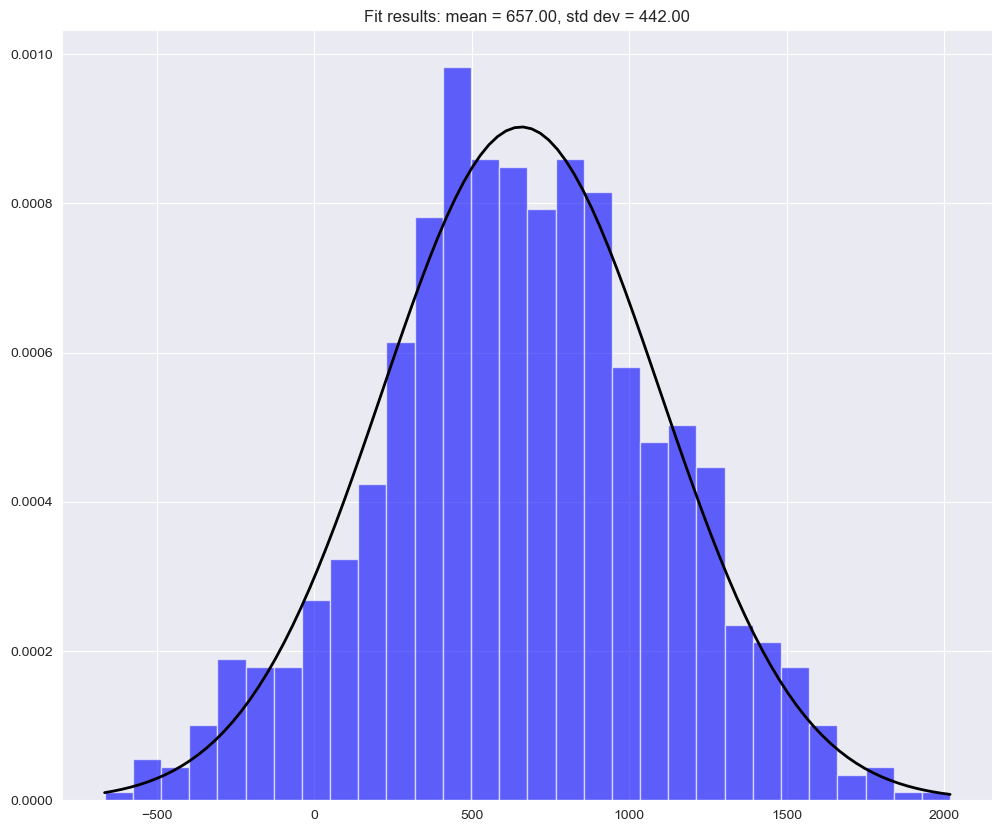

In [52]:
import numpy as np
import matplotlib.pyplot as plt


# Parameters
mean = 657 +  # Mean (μ)
std_dev = 442  # Standard deviation (σ)

# Create a normal distribution with the specified mean and standard deviation
distribution = stats.norm(loc=mean, scale=std_dev)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='b')

# Plot the probability density function (PDF) of the normal distribution
x = np.linspace(min(values), max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
title = f"Fit results: mean = {mean:.2f}, std dev = {std_dev:.2f}"
plt.title(title)
plt.show()


Text(0.5, 1.0, 'Fit results: mean = 30.00, std dev = 10.00')

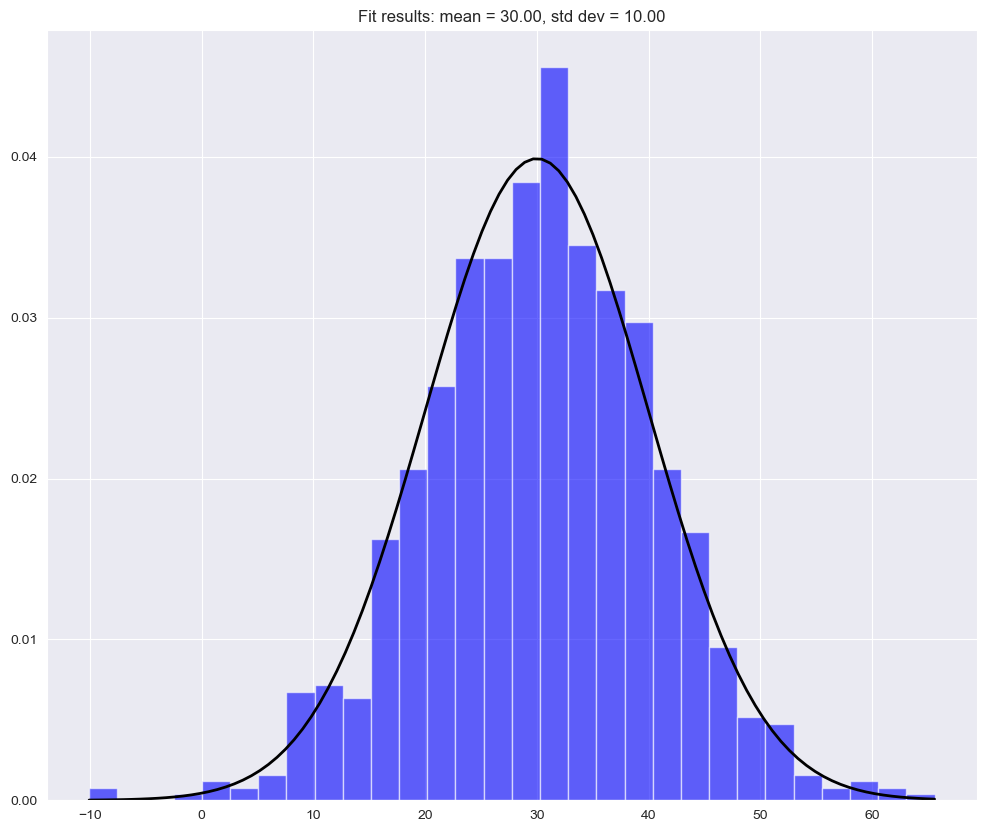

In [71]:
# Parameters
mean = 30  # Mean (μ)
std_dev = 10  # Standard deviation (σ)

# Create a normal distribution with the specified mean and standard deviation
distribution = stats.norm(loc=mean, scale=std_dev)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='b')

# Plot the probability density function (PDF) of the normal distribution
x = np.linspace(np.min(values), np.max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
title = f"Fit results: mean = {mean:.2f}, std dev = {std_dev:.2f}"
plt.title(title)


In [69]:
hr_per_day = 24
gpm = 5
dpy = 365.25

maxpump = 50*24*365.25*60*3.06888E-6
minpump = 1*5*150*60*3.06888E-6
print(minpump,maxpump)

0.1380996 80.70540624


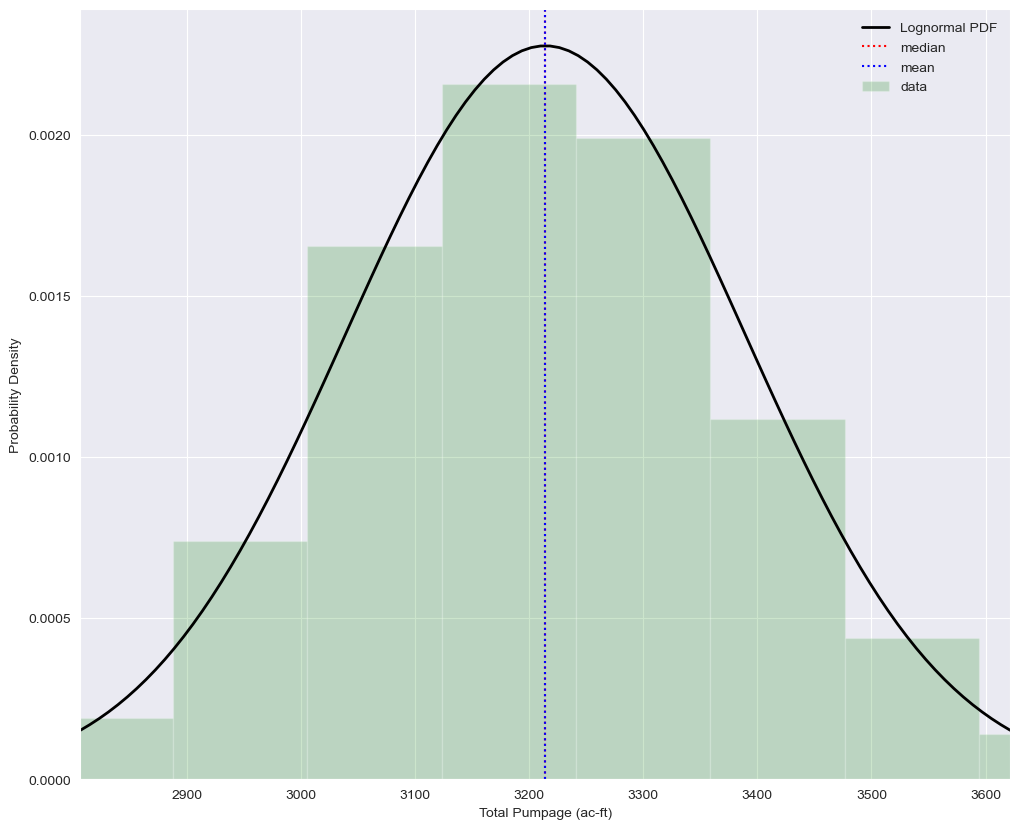

In [100]:
total_pumped_model = []
nwells = 210
for i in range(5000):
    total_pumped_model.append(np.sum(hr_per_day_dist.rvs(size=nwells) * 60 * gpm_dist.rvs(size=nwells) * 3.06889e-6 * 365.25))


totalq_param = stats.norm.fit(total_pumped_model)
qdist = stats.norm(*totalq_param)

fig, ax = plt.subplots(1, 1)
r = qdist.rvs(size=1000)
x = np.linspace(qdist.ppf(0.01), qdist.ppf(0.99), 100)
ax.plot(x, qdist.pdf(x), 'k-', lw=2, label='Lognormal PDF')
#ax.hist(r, density=True, bins='auto', histtype='stepfilled', alpha=0.2)
ax.axvline(qdist.median(),label='median',color='red',linestyle=":")
ax.axvline(qdist.mean(),label='mean',color='blue',linestyle=":")
ax.hist(total_pumped_model, density=True, color='green',alpha=0.2,label='data')
#ax.axvspan(*testdist.interval(0.80),alpha=0.2,color='green')
ax.set_xlim([x[0], x[-1]])
ax.set_xlabel('Total Pumpage (ac-ft)')
ax.set_ylabel("Probability Density")
ax.legend(loc='best', frameon=False)
plt.show()

Text(0.5, 1.0, 'Fit results: mean = 10.00, std dev = 3.00')

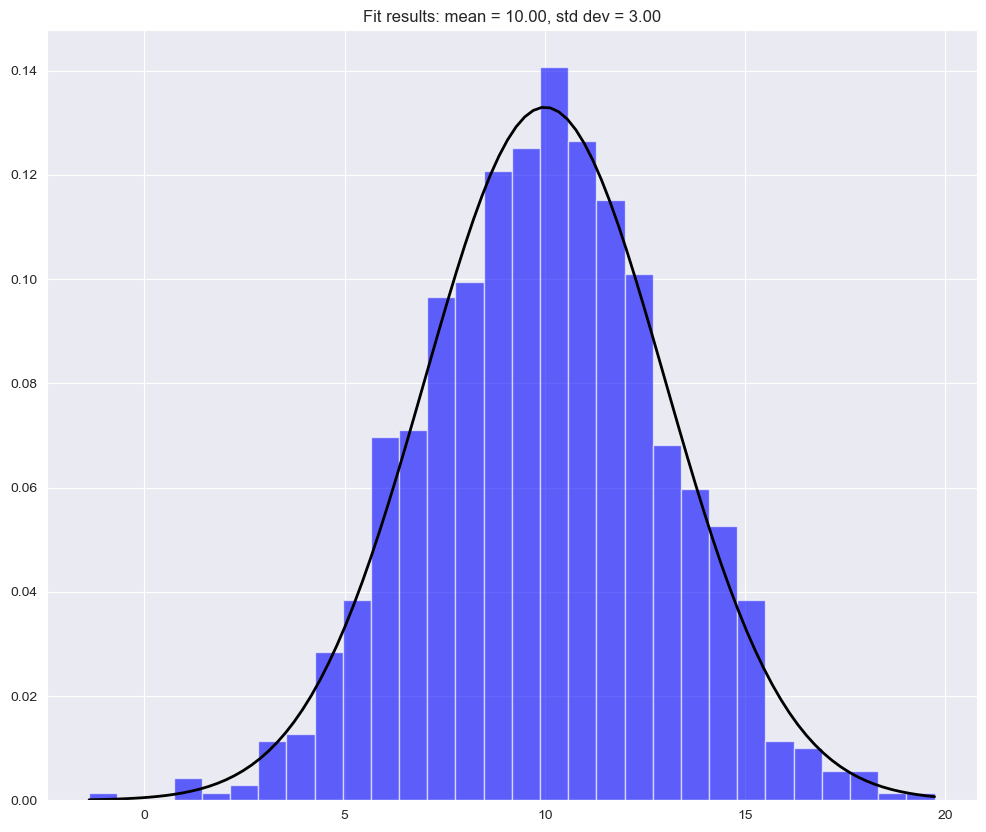

In [74]:

# Parameters
avg = 10  # Mean (μ)
std_dev = 3  # Standard deviation (σ)

# Create a normal distribution with the specified mean and standard deviation
hr_per_day_dist = stats.norm(loc=mean, scale=std_dev)

# Generate values from this distribution
hr_per_day_values = hr_per_day_dist.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(hr_per_day_values, bins=30, density=True, alpha=0.6, color='b')

# Plot the probability density function (PDF) of the normal distribution
x = np.linspace(np.min(hr_per_day_values), np.max(hr_per_day_values), 100)
plt.plot(x, hr_per_day_dist.pdf(x), 'k-', linewidth=2)
title = f"Fit results: mean = {avg:.2f}, std dev = {std_dev:.2f}"
plt.title(title)


Text(0.5, 1.0, 'Fit results: mean = 3.00, std dev = 5.00')

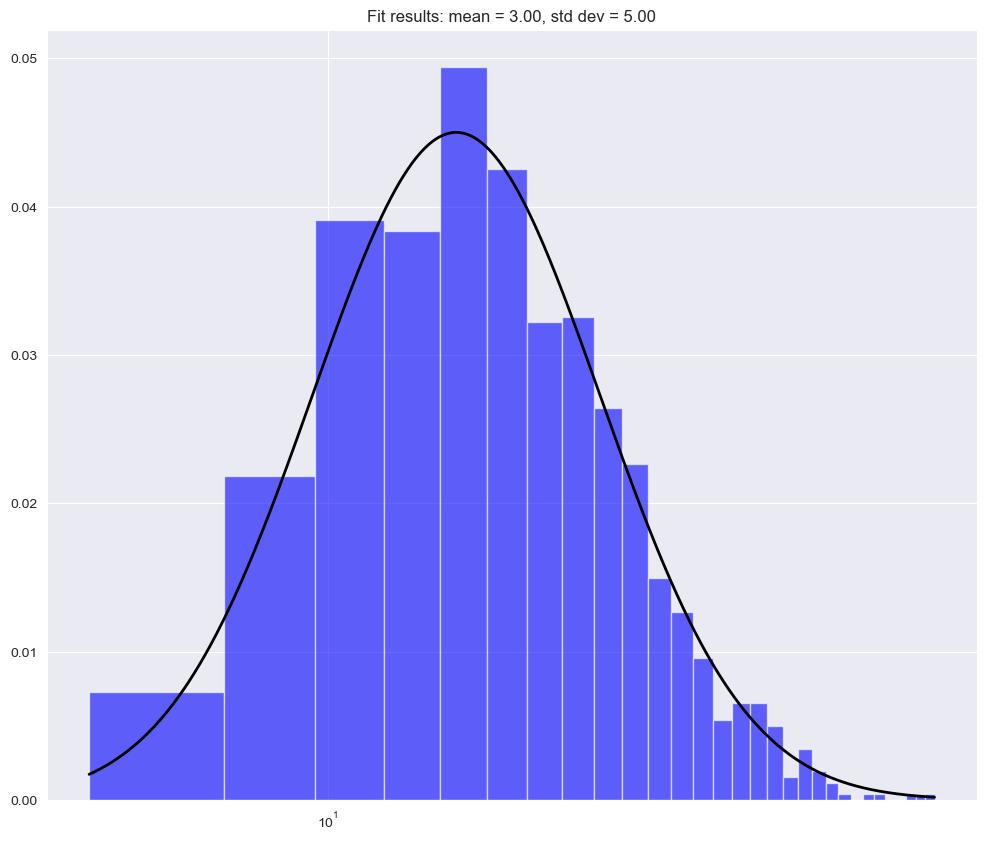

In [99]:
# Parameters for the underlying normal distribution
mu = 3 # Mean of the underlying normal distribution
sigma = 0.5 # Standard deviation of the underlying normal distribution

# Create a lognormal distribution
# scipy's lognorm takes sigma as the shape parameter and scale = exp(mu)
scale = np.exp(mu)
gpm_dist  = stats.lognorm(s=sigma, scale=scale)


# Generate values from this distribution
gpm_values = gpm_dist.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(gpm_values, bins=30, density=True, alpha=0.6, color='b')

# Plot the probability density function (PDF) of the normal distribution
x = np.geomspace(np.min(gpm_values), np.max(gpm_values), 1000)
plt.plot(x, gpm_dist.pdf(x), 'k-', linewidth=2)
plt.xscale('log')
title = f"Fit results: mean = {mu:.2f}, std dev = {std_dev:.2f}"
plt.title(title)


In [ ]:

# Parameters
avg = 350  # Mean (μ)
std_dev = 5  # Standard deviation (σ)

# Create a normal distribution with the specified mean and standard deviation
day_per_year_dist = stats.norm(loc=mean, scale=std_dev)

# Generate values from this distribution
hr_per_day_values = hr_per_day_dist.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(hr_per_day_values, bins=30, density=True, alpha=0.6, color='b')

# Plot the probability density function (PDF) of the normal distribution
x = np.linspace(np.min(hr_per_day_values), np.max(hr_per_day_values), 100)
plt.plot(x, hr_per_day_dist.pdf(x), 'k-', linewidth=2)
title = f"Fit results: mean = {avg:.2f}, std dev = {std_dev:.2f}"
plt.title(title)


In [49]:
# Parameters for the gamma distribution
shape = 2  # Shape parameter, k or alpha
scale = 1  # Scale parameter, theta (theta = 1/beta)

# Create a gamma distribution
distribution = gamma(a=shape, scale=scale)

# Generate values from this distribution
values = distribution.rvs(size=1000)

# Plot the histogram of the generated values
plt.hist(values, bins=30, density=True, alpha=0.6, color='r')

# Plot the probability density function (PDF) of the gamma distribution
x = np.linspace(min(values), max(values), 100)
plt.plot(x, distribution.pdf(x), 'k-', linewidth=2)
title = f"Fit results: shape = {shape:.2f}, scale = {scale:.2f}"
plt.title(title)
plt.show()

5.040635399999999

# Spring Flow Estimates

In [192]:
hydro_regions = gpd.read_file("C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/valley_divisions.gpkg")
sources_geo = gpd.read_file(gis_path / "WaterRights_sources.gpkg", layer="sources")


In [195]:
valley = hydro_regions[(hydro_regions['Bdrk_v_Valley']=='Valley')]
source_pnts = sources_geo.to_crs(valley.crs) 
points_within_polygon = gpd.sjoin(source_pnts, valley, how="inner", op='within')

C:\Users\paulinkenbrandt\Anaconda3\envs\pygis311v4\Lib\site-packages\IPython\core\interactiveshell.py:3517: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [202]:
valley_springs = points_within_polygon[(points_within_polygon['source_status']=='Active')&(points_within_polygon['source_type']=='Spring')]
valley_springs.to_file("C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/valley_springs.gpkg")

<Axes: >

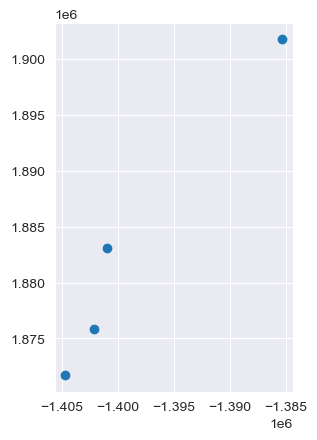

In [4]:
import geopandas as gpd
valley_springs = gpd.read_file("C:/Users/paulinkenbrandt/Documents/ArcGIS/Projects/Pahvant/valley_springs.gpkg")
valley_springs.plot()

In [204]:
valley_springs.set_index('source_id', inplace=True)

In [206]:
spring_recrds = recrds[recrds['source_id'].isin(valley_springs.index)]
yearly_pws_spring_flow = spring_recrds.groupby([localrecrds['source_id'],localrecrds['date'].dt.year]).sum(numeric_only=True)

spr_uses_2022 = yearly_pws_spring_flow[yearly_pws_spring_flow.index.get_level_values(1)==2022]
Total_Spr_Use_2022 = spr_uses_2022.sum()['wuse']*0.00000306889
print(f"Municipal Spring Use in 2022 was {Total_Spr_Use_2022:0.0f} ac-ft/yr")

Municipal Spring Use in 2022 was 907 ac-ft/yr


In [212]:
spr_dist = stats.norm(loc=907,scale=100)
# Calculate quantiles
quantiles = [0.025, 0.975]  # 25th, 50th (median), and 75th percentiles
quantile_values = [spr_dist.ppf(q) for q in quantiles]

# Print the results
print("Quantiles:")
for q, value in zip(quantiles, quantile_values):
    print(f"{q*100}%: {value}")

Quantiles:
2.5%: 711.0036015459946
97.5%: 1102.9963984540054


In [220]:
spr_dist = stats.norm(loc=907,scale=100)
et_dist = stats.norm(loc=4165,scale=1666)
well_dist = stats.norm(loc=145603,scale=7880)
total_discharge_model = []

for i in range(5000):
    discharge = np.sum(spr_dist.rvs(size=1) + et_dist.rvs(size=1))# +well_dist.rvs(size=1))

    total_discharge_model.append(discharge)

totalq_dis_param = stats.norm.fit(total_discharge_model)

totalq_dis_param

(5053.947604302615, 1662.820618357608)

In [216]:
localrecrds = recrds[recrds['source_id'].isin(sources_geo.index)]
localrecrds['WIN'] =localrecrds['source_id'].map(win_match_dict)
localrecrds['daysinmonth'] = localrecrds['date'].dt.daysinmonth
localrecrds['Source Type'] = localrecrds['source_id'].map(sourcetype)
gpmest = localrecrds[(localrecrds['wuse']>1000)&(localrecrds['Source Type'].isin(['Irrigation','Agricultural']))&(localrecrds['date'].dt.month.isin([4,5,6,7,8,9,10]))]
gpmest['gal per day'] = gpmest['wuse']/gpmest['daysinmonth']
gpmest['gpm'] = gpmest['gal per day']* 0.000694444
gpmdata = gpmest.groupby('source_id').max()
#gpmdata['WIN'] = gpmdata.index.map(win_match_dict)
gpmdata = gpmdata[gpmdata['gpm'] > 10]